## 6.4 ディープラーニングの実装

### 確率的勾配降下法

Epoch:0/1000 Error_train:1.1073927810465725 Error_test:1.1070909284759831
Epoch:100/1000 Error_train:0.023983694295725323 Error_test:0.07514228548167051
Epoch:200/1000 Error_train:0.007905620109497786 Error_test:0.08654807421964482
Epoch:300/1000 Error_train:0.003083931215164578 Error_test:0.10171160281810933
Epoch:400/1000 Error_train:0.0016921402929101362 Error_test:0.11411433021679672
Epoch:500/1000 Error_train:0.0011050732456303579 Error_test:0.1231186379265943
Epoch:600/1000 Error_train:0.0007992073399811576 Error_test:0.1305198008166948
Epoch:700/1000 Error_train:0.0006135779610340048 Error_test:0.13682958010356186
Epoch:800/1000 Error_train:0.0004931213590421275 Error_test:0.14219715550524425
Epoch:900/1000 Error_train:0.00040646671609119634 Error_test:0.14748116793631963


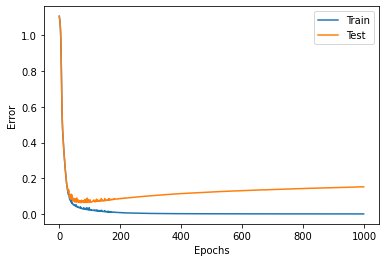

Accuracy Train: 100.0% Accuracy Test: 96.0%


In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# -- Irisデータの読み込み --
iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct)  # サンプル数

# -- 入力データを標準化する --
ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

# -- 正解をone-hot表現にする --
correct_data = np.zeros((n_data, 3))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0

# -- 訓練データとテストデータ --
index = np.arange(n_data) # index←[0,1,2,3…149]
index_train = index[index%2 == 0] # index_train←[0,2,4,6…148]
index_test = index[index%2 != 0] # index_test←[1,3,5,7…149]

input_train = input_data[index_train, :]  # 訓練 入力
correct_train = correct_data[index_train, :]  # 訓練 正解
input_test = input_data[index_test, :]  # テスト 入力
correct_test = correct_data[index_test, :]  # テスト 正解

n_train = input_train.shape[0]  # 訓練データのサンプル数
n_test = input_test.shape[0]  # テストデータのサンプル数

# -- 各設定値 --
n_in = 4  # 入力層のニューロン数
n_mid = 25  # 中間層のニューロン数
n_out = 3  # 出力層のニューロン数

wb_width = 0.1  # 重みとバイアスの広がり具合
eta = 0.01  # 学習係数
epoch = 1000 # 学習する回数
batch_size = 8
interval = 100  # 経過の表示間隔


# -- 各層の継承元 --
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)  # 重み（行列）
        self.b = wb_width * np.random.randn(n)  # バイアス（ベクトル）

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

# -- 中間層 --
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u) # ReLU
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)  # ReLUの微分

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 

# -- 出力層 --
class OutputLayer(BaseLayer):     
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)  # ソフトマックス関数

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 
        

# -- 各層の初期化 --
middle_layer_1 = MiddleLayer(n_in, n_mid)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
output_layer = OutputLayer(n_mid, n_out)

# -- 順伝播 --
def forward_propagation(x):
    middle_layer_1.forward(x)
    middle_layer_2.forward(middle_layer_1.y)
    output_layer.forward(middle_layer_2.y)

# -- 逆伝播 --
def backpropagation(t):
    output_layer.backward(t)
    middle_layer_2.backward(output_layer.grad_x)
    middle_layer_1.backward(middle_layer_2.grad_x)

# -- 重みとバイアスの更新 --
def uppdate_wb():
    middle_layer_1.update(eta)
    middle_layer_2.update(eta)
    output_layer.update(eta)

# -- 誤差を計算 --
def get_error(t, batch_size):
    return -np.sum(t * np.log(output_layer.y + 1e-7)) / batch_size  # 交差エントロピー誤差


# -- 誤差の記録用 --
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

# -- 学習と経過の記録 --
n_batch = n_train // batch_size  # 1エポックあたりのバッチ数
for i in range(epoch):

    # -- 誤差の計測 --  
    forward_propagation(input_train)
    error_train = get_error(correct_train, n_train)
    forward_propagation(input_test)
    error_test = get_error(correct_test, n_test)
    
    # -- 誤差の記録 -- 
    test_error_x.append(i)
    test_error_y.append(error_test) 
    train_error_x.append(i)
    train_error_y.append(error_train) 
    
    # -- 経過の表示 -- 
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
              "Error_train:" + str(error_train),
              "Error_test:" + str(error_test))

    # -- 学習 -- 
    index_random = np.arange(n_train)
    np.random.shuffle(index_random)  # インデックスをシャッフルする
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]
        
        # 順伝播と逆伝播
        forward_propagation(x)
        backpropagation(t)
        
        # 重みとバイアスの更新
        uppdate_wb()

        
# -- 誤差の記録をグラフ表示 -- 
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# -- 正解率の測定 -- 
forward_propagation(input_train)
count_train = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_train, axis=1))

forward_propagation(input_test)
count_test = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_test, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
      "Accuracy Test:", str(count_test/n_test*100) + "%")